# Correction zone stability analysis

## Analytical solution to stability map

We want to know how much a trajectory deviates over one temporal cycle as a function of its starting location and the correction zone parameters.

Let 

$$t^* = h/v_s + (1-h)/v_f$$

be the time it would take to pass through 1 spatial correction zone cycle if there were no temporal modulation.

The total displacement after one temporal cycle is

$\Delta x = (1-w)v_f + w//t^* + r_x(x_0)$

where the first term accounts for the time the temporal modulation is silent, the second term is the integer number ($n_c = w//t^*$) of complete correction zone cycles passed through  during while the temporal modulation is on ($w$) and $r_x$ is the leftover travel distance beyond the integer correction zone multiple, which depends on the starting point $x_0$.

The time not accounted for by the integer multiple of correction zones is

$$r_t = w - t^*(w//t*)$$

which is less than $t^*$ by construction.

Unfortunately there are 6 possible scenarios for $r_x$ as a func of $x_0$ (defined btwn 0 and 1):

1. $x$ starts inside and stays inside the czone. Occurs if $0 \leq x_0 < h$ and $r_t < (h - x_0)/v_s$. Then $r_x = v_sr_t$.
2. $x$ starts inside and ends up outside the czone. Occurs if $0 \leq x_0 < h$ and $(h - x_0)/v_s \leq r_t < (h-x_0)/v_s + (1-h)/v_f$. Then $r_x = h-x_0 + [r_t - (h - x_0)/v_s]v_f$.
3. $x$ starts inside, leaves, then renters the czone. Occurs if $0 \leq x_0 < h$ and $(h-x_0)/v_s + (1-h)/v_f \leq r_t$. Then $r_x = (1-h) + [r_t-(1-h)/v_f]v_s$.
4. $x$ starts outside and stays outside the czone. Occurs if $h \leq x_0 < 1$ and $r_t < (1 - x_0)/v_f$. Then $r_x = v_fr_t$
5. $x$ starts outside and ends up inside the czone. Occurs if $h \leq x_0 < 1$ and $(1 - x_0)/v_f \leq r_t < (1-x_0)/v_f + h/v_s$. Then $r_x = 1-x_0 + [r_t-(1 - x_0)/v_f]v_s$.
6. $x$ starts outside, enters, then leaves the czone. Occurs if $h \leq x_0 < 1$ and $(1-x_0)/v_f + h/v_f \leq r_t$. Then $r_x = h + [r_t-h/v_s]v_f$.

In [1]:
%matplotlib inline
from itertools import product as c_prdt
import matplotlib.pyplot as plt
import numpy as np

from aux import Generic
from disp import set_font_size, get_spaced_colors


N_X = 500
N_T = 1001

X_0 = np.linspace(-1, 1, 2*N_X)

T = np.linspace(0, 1, N_T)


def run_smln(x_0, w, h, v_f, v_s):
    """Simulate trj thru one temporal cycle."""
    x = np.nan * np.zeros(T.shape)
    x[0] = x_0
    
    for ct, t_ in enumerate(T[1:], 1):
        
        # set v slow if in czone else fast
        if (0 <= x[ct-1] % 1 < h) and (0 <= t_ % 1 < w):
            v = v_s
        else:
            v = v_f
            
        # update x
        x[ct] = x[ct-1] + v*(T[ct] - T[ct-1])
    return x


def calc_dx_s(x_0, w, h, v_f, v_s):
    """Calculate change in x analytically relative to one spatial period."""
    
    x_0 = x_0 % 1  # constrain btwn 0 and 1
    
    t_star = h/v_s + (1-h)/v_f
    n_c = np.floor(w/t_star)
    r_t = w - t_star*n_c
    
    # starts in, stays in
    if (0 <= x_0 < h) and (r_t < (h-x_0)/v_s):
        r_x = v_s*r_t
        
    # starts in, leaves
    elif (0 <= x_0 < h) and ((h-x_0)/v_s <= r_t < ((h-x_0)/v_s + (1-h)/v_f)):
        r_x = (h-x_0) + (r_t - (h-x_0)/v_s)*v_f
    
    # starts in, leaves, enters
    elif (0 <= x_0 < h) and (((h-x_0)/v_s + (1-h)/v_f) <= r_t):
        r_x = (1-h) + (r_t - (1-h)/v_f)*v_s
        
    # starts out, stays out
    elif (h <= x_0 < 1) and (r_t < (1-x_0)/v_f):
        r_x = v_f*r_t
        
    # starts out, enters
    elif (h <= x_0 < 1) and ((1-x_0)/v_f <= r_t < ((1-x_0)/v_f + h/v_s)):
        r_x = 1-x_0 + (r_t - (1-x_0)/v_f)*v_s
        
    # starts out, enters, leaves
    elif (h <= x_0 < 1) and ((1-x_0)/v_f + h/v_s <= r_t):
        r_x = h + (r_t - h/v_s)*v_f
    
    dx = (1-w)*v_f + n_c + r_x
    return dx - 1

Example stability map and trajectories

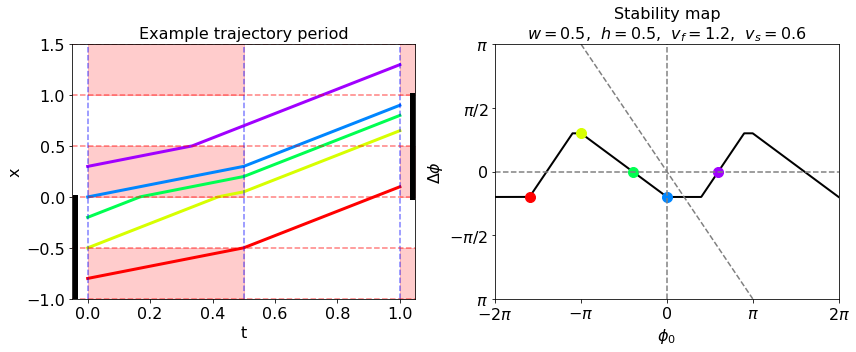

In [2]:
w = .5
h = .5

v_f = 1.2
v_s = .6

x_0_xpl = [-.8, -.5, -.2, 0, .3]
x_xpl = []
dx_s_xpl = []

for x_0 in x_0_xpl:
    x_xpl.append(run_smln(x_0, w, h, v_f, v_s))
    dx_s_xpl.append(calc_dx_s(x_0, w, h, v_f, v_s))

dx_s = np.array([calc_dx_s(x_0, w, h, v_f, v_s) for x_0 in X_0])


fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# xpl trjs
c = get_spaced_colors('hsv', len(x_0_xpl), 50/256)

for t_, x_ in c_prdt((-1, 0, 1), (-1, 0, 1)):
    axs[0].fill_between([t_, t_ + w], [x_, x_], [x_ + h, x_ + h], color='r', alpha=.2)

for x, c_ in zip(x_xpl, c):
    axs[0].plot(T, x, color=c_, lw=3)
    
axs[0].axvline(0, color='b', ls='--', alpha=.5)
axs[0].axvline(w, color='b', ls='--', alpha=.5)
axs[0].axvline(1, color='b', ls='--', alpha=.5)

for x_ in (-1, 0, 1):
    axs[0].axhline(x_, color='r', ls='--', alpha=.5)
    axs[0].axhline(x_ + h, color='r', ls='--', alpha=.5)
    
axs[0].plot([-.04, -.04], [-1, 0], c='k', lw=5)
axs[0].plot([1.04, 1.04], [0, 1], c='k', lw=5)

axs[0].set_xlim(-.05, 1.05)
axs[0].set_ylim(-1, 1.5)

axs[0].set_xlabel('t')
axs[0].set_ylabel('x')
axs[0].set_title('Example trajectory period')


# stability map
axs[1].plot(2*np.pi*X_0, 2*np.pi*dx_s, lw=2, c='k', zorder=0)

## locs of xpl trjs on stability map
for x_0, dx_s_, c_ in zip(x_0_xpl, dx_s_xpl, c):
    axs[1].scatter(2*np.pi*x_0, 2*np.pi*dx_s_, s=100, c=[c_], zorder=1)

axs[1].axhline(0, color='gray', ls='--')
axs[1].axvline(0, color='gray', ls='--')
axs[1].plot([-np.pi, np.pi], [np.pi, -np.pi], c='gray', ls='--')

axs[1].set_xlim(-2*np.pi, 2*np.pi)
axs[1].set_ylim(-np.pi, np.pi)

axs[1].set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
axs[1].set_xticklabels(['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])
axs[1].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
axs[1].set_yticklabels(['$\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[1].set_xlabel('$\phi_0$')
axs[1].set_ylabel('$\Delta \phi$')
axs[1].set_title(
    'Stability map\n$w = {},\:\:h = {},\:\:v_f = {},\:\:v_s = {}$'.format(w, h, v_f, v_s))

for ax in axs:
    set_font_size(ax, 16)